# Assignment Two &mdash; CSI 5180: Machine Learning for Bioinformatics

**Student Name:** Steven Sun  
**Student ID:** 300067541

# Variables, Parameters, and Hyperparameters for Changing the Behaviour and Outputs of Traditional Machine Learning (Sections Prior to CNN)
* Please read this markdown cell for generating all possible outputs required for marking this assignment.
* In **Standard Data Partitioning, Training and Testing**
  * Inside the function ```do_classification(X, y)```
    * Choose either ```class_rebalance_methods``` or ```best_rebalance_method``` in ```for i, func in enumerate(best_rebalance_method)```
    ```
    class_rebalance_methods = [baseline_experiment, weight_adjustment, random_oversampling]
    best_rebalance_method = [random_oversampling]
    ```
    * The following variables toggle the training and validation process:
    ```
    search_for_best_params = True
    train_and_test = True
    ```
    ```
    # Must run only one machine learning algorithm at a time
    # Not Two
    l_r = True
    r_f = not l_r
    ```
* In **Run All Cells for Traditional Machine Learning**
  * ```run = False``` toggles the execution
  * Examine the loop ```for run in [2]: # To use all 3 runs, try [0, 1, 2]```
    * ```[0, 1, 2]``` will run all three datasets
    * These variables decide which ```k``` value to run.
    ```
        min_k = 2
        max_k = 6
        best_k = 4
        for i in range(min_k, max_k+1):
    ```

# Loading the Dataset
* Based on Marcel's Assignment 1 - Draft Solution

In [1]:
import requests
from typing import List

class FASTAError(Exception):
    """Custom exception for errors encountered while processing FASTA data."""
    pass

def load_fasta_from_url(url: str) -> List[str]:
    """Fetches a FASTA file from a URL in a (somehow) memory-efficient way and returns a list of sequence strings.

    Raises:
        ConnectionError: If there is an issue fetching data from the URL.
        FASTAError: If the retrieved file is empty or does not contain valid FASTA data.
    """
    try:
        response = requests.get(url, stream=True, timeout=10)
        response.raise_for_status()
    except requests.RequestException as e:
        raise ConnectionError(f"Error fetching URL {url}: {e}") from e

    sequences = []
    seq = ""
    has_data = False  # To check if we read any content
    # Process the response line by line to avoid loading the entire file into memory.
    for line in response.iter_lines(decode_unicode=True):
        if line is None:
            continue
        stripped_line = line.strip()
        if not stripped_line:
            continue  # Skip empty lines
        has_data = True
        if stripped_line.startswith(">"):
            if seq:
                sequences.append(seq)
                seq = ""
        else:
            seq += stripped_line
    if seq:
        sequences.append(seq)

    if not has_data:
        raise FASTAError("The retrieved file is empty or not in FASTA format.")
    if not sequences:
        raise FASTAError("No valid sequence data found in the FASTA file.")

    return sequences

# Data Encoding
* Based on Marcel's Assignment 1 - Draft Solution

In [2]:
import itertools
import numpy as np

def kmer_encode(seq: str, k_value: int = 4, one_hot_encoding = False) -> np.ndarray:

    """
    Encodes a nucleotide sequence into a normalized kmer frequency vector.

    Parameters:
        seq (str): Input nucleotide sequence. Only characters A, C, G, T (case-insensitive) are counted.
        k_value (int): Length of kmers to generate. Must be a positive integer and no greater than len(seq).

    Returns:
        np.ndarray: A normalized frequency vector. Each element corresponds to a kmer, ordered lexicographically
                    based on the product of 'ACGT' repeated k_value times.

    Raises:
        TypeError: If seq is not a string.
        ValueError: If k_value is not a positive integer or if seq is shorter than k_value.
    """

    # Validate input types and values.
    if not isinstance(seq, str):
        raise TypeError("The sequence must be a string.")
    if not isinstance(k_value, int) or k_value <= 0:
        raise ValueError("k_value must be a positive integer.")
    if len(seq) < k_value:
        raise ValueError("Sequence length must be at least as long as k_value.")

    # Generate all possible kmers of the given length in lexicographic order.
    kmers = [''.join(p) for p in itertools.product('ACGT', repeat=k_value)]
    kmer_idx = {kmer: idx for idx, kmer in enumerate(kmers)}

    # Convert sequence to uppercase to ensure uniformity.
    seq = seq.upper()

    # Calculate the number of sliding windows.
    total_windows = len(seq) - k_value + 1
    # Initialize a frequency vector with zeros.
    vec = np.zeros(len(kmers), dtype=float)

    # Slide through the sequence one kmer at a time.
    for i in range(total_windows):
        kmer = seq[i:i+k_value]
        # Count the kmer only if it contains valid nucleotide characters.
        if all(base in 'ACGT' for base in kmer):
            vec[kmer_idx[kmer]] += 1

    # Normalize the vector by the total number of windows.
    vec /= total_windows
    return vec

# Addressing Class Imbalance
1. Baseline Experiment
2. Class Weight Adjustment
3. Random Oversampling

Each experiment returns a distinct reformulation of ```X_train```, ```_y_train```, and the ```class_imbalanace``` parameter.

## Baseline Experiment

In [3]:
def baseline_experiment(X_train, y_train):
    return X_train, y_train, None

## Class Weight Adjustment

In [4]:
def weight_adjustment(X_train, y_train):
    return X_train, y_train, "balanced"

## Random Oversampling

In [5]:
from imblearn.over_sampling import RandomOverSampler

def random_oversampling(X_train, y_train):
    ros = RandomOverSampler(random_state=42)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)
    return X_train_resampled, y_train_resampled, None

# Cross-Validation Scores

In [6]:
from sklearn.model_selection import GridSearchCV

def show_cross_validation_scores(X_train, y_train, i, func, param_grid, search_for_best_params, model_type):

    print(f"Running function {i}: {func.__name__}")
    X_train, y_train, class_weight = func(X_train, y_train)

    clf = None

    if model_type == "l_r":
        clf = LogisticRegression(random_state=42, class_weight=class_weight) #Logistic Regression
    elif model_type == "r_f":
        clf = RandomForestClassifier(random_state=42) #Random Forest

    # Define custom scorers
    balanced_acc = make_scorer(balanced_accuracy_score)
    f1_macro = make_scorer(f1_score, average='macro')

    # Stratified 10-Fold CV
    cv = StratifiedKFold(n_splits=10)
    balanced_acc_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=balanced_acc)
    f1_macro_scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=f1_macro)

    # Print results
    print("Cross-validation scores for the model: ", model_type)
    print("Balanced Accuracy: Mean =", balanced_acc_scores.mean(), ", Std =", balanced_acc_scores.std())
    print("Macro F1 Score:     Mean =", f1_macro_scores.mean(), ", Std =", f1_macro_scores.std())
    print()

    if search_for_best_params:
        grid_search = GridSearchCV(clf, param_grid, cv=cv)
        grid_search.fit(X_train, y_train)

        clf = grid_search.best_estimator_  # update clf to the best one
        best_params = grid_search.best_params_
        clf = best_params

        print("Best Params:", best_params)
        print("Best CV Score:", grid_search.best_score_)
        print()

    return clf, X_train, y_train, class_weight


# Train and Evaluate Model

In [7]:
def train_and_evaluate_model(clf, X_train, y_train, X_test, y_test, class_weight, search_for_best_params, model_type):

    if search_for_best_params:
        if model_type == "l_r":
            clf = LogisticRegression(**clf, random_state=42, class_weight=class_weight) #Logistic Regression
        elif model_type == "r_f":
            clf = RandomForestClassifier(**clf, random_state=42) #Random Forest Classifier
        clf.fit(X_train, y_train)

    else:
        clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print()

# Standard Data Partitioning, Training and Testing

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, make_scorer, balanced_accuracy_score, f1_score

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_val_score

def do_classification(X, y):

    # Class Rebalance Methods
    class_rebalance_methods = [baseline_experiment, weight_adjustment, random_oversampling]
    best_rebalance_method = [random_oversampling]

    # Logistic Regression Hyperparameter Grid
    lr_param_grid = {'penalty': ["l2", None],
                     'solver' : ['newton-cg', 'lbfgs'],
                     'max_iter' : [500, 1000, 2000]}

    # Random Forest Hyperparameter Grid
    rf_param_grid = {'max_depth': range(2, 4),
                     'criterion': ["gini", "entropy", "log_loss"]}

    search_for_best_params = True
    train_and_test = True

    # Must run only one machine learning algorithm at a time
    # NOT two
    l_r = True
    r_f = not l_r

    # Run three distinct approaches to address data imbalance
    for i, func in enumerate(best_rebalance_method): # The best rebalance method was chosen

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # for approach i, run function i
        if l_r:
            clf, X_train, y_train, class_weight = show_cross_validation_scores(X_train, y_train, i, func, lr_param_grid, search_for_best_params, "l_r")
        elif r_f:
            clf, X_train, y_train, class_weight = show_cross_validation_scores(X_train, y_train, i, func, rf_param_grid, search_for_best_params, "r_f")

        if train_and_test and l_r:
            train_and_evaluate_model(clf, X_train, y_train, X_test, y_test, class_weight, search_for_best_params, "l_r")
        elif train_and_test and r_f:
            train_and_evaluate_model(clf, X_train, y_train, X_test, y_test, class_weight, search_for_best_params, "r_f")

# Determining the best ```k```
* Based on Marcel's Assignment 1 - Draft Solution

In [9]:
def determine_best_k(k):

    X_pos = np.array([kmer_encode(seq, k) for seq in pos_seqs])
    X_neg = np.array([kmer_encode(seq, k) for seq in neg_seqs])

    X = np.vstack([X_pos, X_neg])
    y = np.concatenate((np.ones(len(X_pos)), np.zeros(len(X_neg))))  # label 1 for promoters, 0 for non-promoters

    print("K-mer feature vector length:", X.shape[1])
    print("Feature vector example (first positive sequence):")
    print(X[0][:5], "...")
    print()

    do_classification(X, y)

# Run All Cells for Traditional Machine Learning
* Based on Marcel's Assignment 1 - Draft Solution

In [10]:
# URLs to raw FASTA files on GitHub

BASE_URL = "https://raw.githubusercontent.com/solovictor/CNNPromoterData/refs/heads/master/"

runs = [["Arabidopsis_tata.fa", "Arabidopsis_non_prom_big.fa"],
        ["Arabidopsis_non_tata.fa", "Arabidopsis_non_prom_big.fa"],
        ["Arabidopsis_tata + Arabidopsis_non_tata", "Arabidopsis_non_prom_big.fa"]]

run = False

if run:
    for run in [2]: # To use all 3 runs, try [0, 1, 2]

        print()
        print()
        print("Experiment:", runs[run][0])

        # Load sequences from each file

        pos_seqs = []
        neg_seqs = []

        if run == 2:
            pos_seqs_tata = load_fasta_from_url(BASE_URL + runs[0][0])
            pos_seqs_non_tata = load_fasta_from_url(BASE_URL + runs[1][0])
            pos_seqs = pos_seqs_tata + pos_seqs_non_tata
            neg_seqs = load_fasta_from_url(BASE_URL + runs[run][1])
        else:
            pos_seqs = load_fasta_from_url(BASE_URL + runs[run][0])
            neg_seqs = load_fasta_from_url(BASE_URL + runs[run][1])

        print(f"Loaded {len(pos_seqs)} ({len(pos_seqs)/(len(pos_seqs)+len(neg_seqs))*100:.1f}%) positive \
        sequences and {len(neg_seqs)} ({len(neg_seqs)/(len(pos_seqs)+len(neg_seqs))*100:.1f}%) negative sequences.")

        print("Example positive sequence:", pos_seqs[0][:50], "...")
        print("Example negative sequence:", neg_seqs[0][:50], "...")

        min_k = 2
        max_k = 6
        best_k = 4
        for i in range(best_k, best_k+1):

            print()
            print("k = ", i)
            print()
            determine_best_k(i)

# Discussion

## Class Imbalance Mitigation Methods for All Three Datasets
* When positive = ‘Arabidopsis_tata.fa’, negative = ‘Arabidopsis_non_prom_big.fa’, the testing macro average score was good at ~ 0.84. When positive = ‘Arabidopsis_non_tata.fa’, negative = ‘Arabidopsis_non_prom_big.fa’, the testing macro average was very good at ~ 0.90. When positive = ‘Arabidopsis_tata.fa’ + ‘Arabidopsis_non_tata.fa’, negative = ‘Arabidopsis_non_prom_big.fa’, the testing macro average was excellent at ~ 0.91.
* If I evaluate the effectiveness of the class imbalance mitigation method independent of the dataset, the cross-validation macro f1 score was the highest when the random oversampling was employed.
* Consequently, empirical results suggest me to use ```RandomOverSampler``` to find best ```k```.

## Finding the best ```k```
* From the results obtained by cross-validation, balanced accuracy and the macro-averaged f1 score increase as ```k``` increases, from 2 to 6.
* However, the testing macro-average f1 peaked at ```k``` = 4, suggesting that the best ```k``` is indeed 4.

## Hyperparameter Optimization
* Using ```RandomOverSampler``` and ```k``` = 4, and a hyperparameter grid specified below for logistic regression and random forest:
```
# Logistic Regression Hyperparameter Grid
    lr_param_grid = {'penalty': ["l2", None],
                     'solver' : ['newton-cg', 'lbfgs'],
                     'max_iter' : [500, 1000, 2000]}
```
```
# Random Forest Hyperparameter Grid
    rf_param_grid = {'max_depth': range(1, 10),
                     'criterion': ["gini", "entropy", "log_loss"]}
```

* The results are as follows for logistic regression:
```
Cross-validation scores for the model:  l_r
Balanced Accuracy:  Mean = 0.9158411828013314 , Std = 0.007080918705189352
Macro F1 Score:     Mean = 0.9158329921072974 , Std = 0.007082918226591573
```
```
Best Params: {'max_iter': 500, 'penalty': 'l2', 'solver': 'newton-cg'}
Best CV Score: 0.9161132003181702
```
```
              precision    recall  f1-score   support

         0.0        0.95      0.91      0.93      2292
         1.0        0.87      0.93      0.90      1481
    accuracy                            0.92      3773
   macro avg        0.91      0.92      0.91      3773
weighted avg      0.92      0.92      0.92      3773
```
* The results are as follows for random forest:
```
Cross-validation scores for the model:  r_f
Balanced Accuracy:  Mean = 0.9325940031334378 , Std = 0.017385501238222256
Macro F1 Score:     Mean = 0.9325595163301251 , Std = 0.01734288191285531
```
```
Best Params: {'criterion': 'gini', 'max_depth': 3}
Best CV Score: 0.8665328364451315
```
```
            precision    recall  f1-score   support

         0.0       0.92      0.86      0.89      2292
         1.0       0.80      0.88      0.84      1481

    accuracy                           0.87      3773
   macro avg       0.86      0.87      0.86      3773
weighted avg     0.87      0.87      0.87      3773
```
The macro-average f1 score is higher when logistic regression is used over random forest on the testing dataset.

# Preparing for Deep Learning



## Load and obtain the third *sequence* dataset

In [11]:
# Load sequences from each file

pos_seqs = []
neg_seqs = []

pos_seqs_tata = load_fasta_from_url(BASE_URL + runs[0][0])
pos_seqs_non_tata = load_fasta_from_url(BASE_URL + runs[1][0])
pos_seqs = pos_seqs_tata + pos_seqs_non_tata
neg_seqs = load_fasta_from_url(BASE_URL + runs[2][1])

print(f"Loaded {len(pos_seqs)} ({len(pos_seqs)/(len(pos_seqs)+len(neg_seqs))*100:.1f}%) positive \
    sequences and {len(neg_seqs)} ({len(neg_seqs)/(len(pos_seqs)+len(neg_seqs))*100:.1f}%) negative sequences.")

print("Example positive sequence:", pos_seqs[0][:50], "...")
print("Example negative sequence:", neg_seqs[0][:50], "...")
print("Length of a positive sequence:", len(pos_seqs[0]))
print("Length of a negative sequence:", len(neg_seqs[0]))

Loaded 7402 (39.2%) positive     sequences and 11459 (60.8%) negative sequences.
Example positive sequence: CAAGTATCCTACATAGATTATAGGAGTGACCGCAAAAACACAAACTATGT ...
Example negative sequence: CATTCTCTCGGACGGCCGTGAATTTTGCGGCAGGATGTGAGACAGCAATG ...
Length of a positive sequence: 251
Length of a negative sequence: 251


## One-Hot Encoding

* Based on Marcel's slides on Convolutional Neural Networks

In [35]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Define fixed DNA bases
bases = ['A', 'C', 'G', 'T']

# Pre-fit the LabelEncoder with fixed bases
integer_encoder = LabelEncoder()
integer_encoder.fit(bases)

# Use the fixed integer mapping to define OneHotEncoder categories
categories = [integer_encoder.transform(bases)]

# For X: One-hot encoder utilizes the label encoder
one_hot_encoder = OneHotEncoder(categories=categories)

sequences = pos_seqs + neg_seqs

y = [1] * len(pos_seqs) + [0] * len(neg_seqs)
y = np.array(y).reshape(-1, 1)

input_features = []

# For X, one-hot encode one sample/sequence at a time
for i, sequence in enumerate(sequences):
    integer_encoded = integer_encoder.fit_transform(list(sequence))
    integer_encoded = np.array(integer_encoded).reshape(-1, 1)

    # One-Hot Encode only valid sequences
    if all(char in bases for char in sequence):
        one_hot_encoded = one_hot_encoder.fit_transform(integer_encoded)
        input_features.append(one_hot_encoded.toarray())
    # Delete labels associated with invalid sequences
    else:
        y = np.delete(y, i, axis=0)


X = np.stack(input_features)

print('One hot encoding of Sequence #1:\n',X[0].T)
print()
print('labels:\n', y.T)
print()

One hot encoding of Sequence #1:
 [[0. 1. 1. ... 1. 0. 1.]
 [1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]

labels:
 [[1 1 1 ... 0 0 0]]



# Convolutional Neural Networks

* Adapted from Marcel's Lecture 17

In [58]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, GlobalMaxPooling1D,Dropout
from tensorflow.keras.models import Sequential

# hyperparameters
filters = 32 # was 32
kernel_size = 5 # was 5
num_conv_layers = 2 # was 2

model = Sequential()
for i in range(num_conv_layers - 1):
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, input_shape=(X_train.shape[1], 4), activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=filters, kernel_size=kernel_size, input_shape=(X_train.shape[1], 4), activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu', kernel_initializer="he_normal"))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['binary_accuracy'])

model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_27 (Conv1D)                   │ (None, 247, 32)             │             672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_14 (MaxPooling1D)      │ (None, 123, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_28 (Conv1D)                   │ (None, 119, 32)             │           5,152 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_13              │ (None, 32)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,001 (31.25 KB)

 Trainable params: 8,001 (31.25 KB)

 Non-trainable params: 0 (0.00 B)

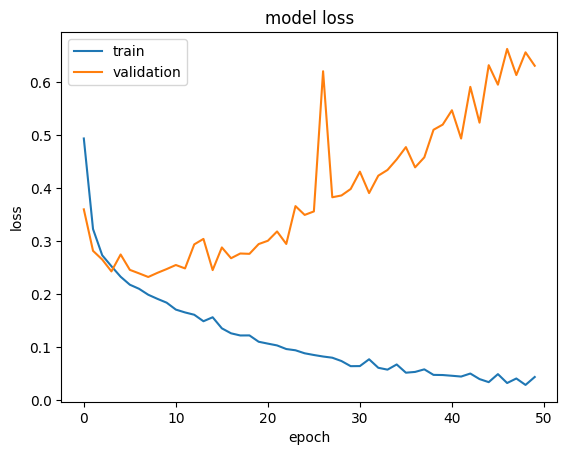

In [55]:
history = model.fit(X_train, y_train, epochs=50, verbose=0, validation_split=0.1, batch_size=32)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

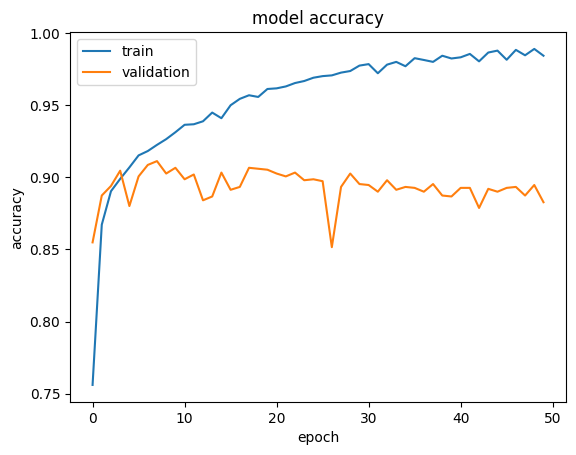

In [56]:
plt.figure()
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

**The best epoch is around 8 or 9.**

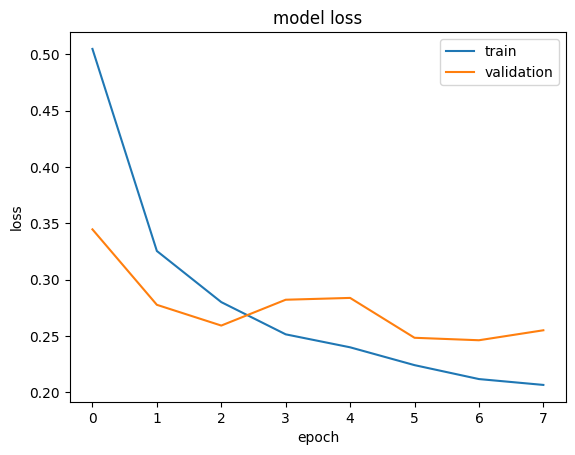

In [60]:
# Retrain using epochs = 8

history = model.fit(X_train, y_train, epochs=8, verbose=0, validation_split=0.1, batch_size=32)

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show()

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

           0       0.91      0.93      0.92      2302
           1       0.89      0.86      0.88      1470

    accuracy                           0.90      3772
   macro avg       0.90      0.90      0.90      3772
weighted avg       0.90      0.90      0.90      3772



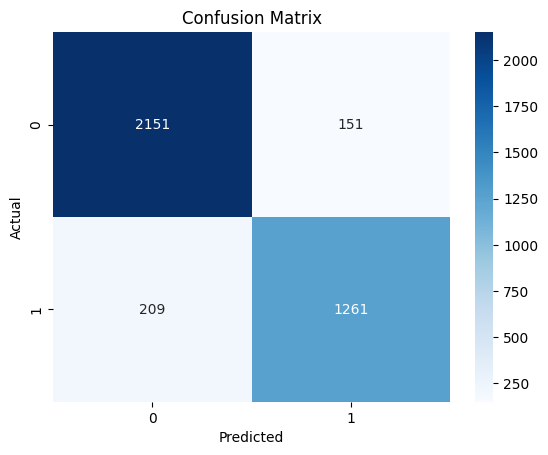

In [61]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(np.stack(X_test))
y_pred = (np.array(y_pred) >= 0.5).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Discussion

While hyperparameter tuning was not demonstrated empirically in this notebook, I have personally tested various hyperparameters such as:
- Increasing/Decreasing the number of convolutional layers
- Increasing/Decreasing the number of kernels per layer
- Increasing/Decreasing filter sizes
---
The results show that:
- High number of convolutional layers leads to overfitting, while low number of
convolutional layers leads to underfitting.
- High number of kernels leads to overfitting, while low number of
kernels leads to underfitting.
- Large filter sizes lead to overfitting, while small filter sizes lead to underfitting.
---
**Comments on the visuals**
- Validation loss and accuracies tend to exhibit spiky progression, suggesting that a mix of lasso or ridge regularization can smoothen the curves.
- The training peaks very early at epoch = 8, implying that overfitting occurs much more rapidly than ideal. Other models and alternative data encoding schemes may be explored and contrasted against the currently employed CNN architecture to produce significantly higher long-term accuracies and lower long-term losses.
